Student Details

### Name: Abhijit Sinha

### ID: 18195067

# Lab 4: Comparison of Classifiers

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from scipy import interp

# Using a global random seed for reproducible results when doing multiple runs
np.random.seed(0)

# Suppressing FutureWarnings from scikit-learn
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### Import evaluation and plotting functions

In [2]:
%run ./Etivity4_18195067_Functions.ipynb

## Task 1 (CS5062)
- data set loans_et4.csv. This is a modified version of the loans data set with 1 for Loan_Status = Yes and 0 for Loan_Status = No. You are asked to work with this data set in Tasks 1-3.
- Replicate the classifier training and evaluation demonstrated in the main example notebook Lab 4 - Comparison of Classifiers - Main.ipynb but with the data set loans_et4.csv and target attribute Loan_Status. 
- Then train another probabilistic classifier with loans_et4.csv add compare it to both SVM and Naïve Bayes. For this third classifier, you can pick any scikit-learn probabilistic classification 

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("./loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [4]:
lab4_df.shape

(480, 12)

In [5]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Target analysis

In [6]:
target.describe()

count    480.000000
mean       0.691667
std        0.462287
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Loan_Status, dtype: float64

In [7]:
target.value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [8]:
target.value_counts(normalize=True)

1    0.691667
0    0.308333
Name: Loan_Status, dtype: float64

### Observation from target analysis:
The target is imbalanced as we have 69% of 1's and 31% of 0's.

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [9]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [10]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(gamma='auto', probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, prec_SVM, rec_SVM = evaluate_classifier(folds=5, 
                                                                                           p=predictors, 
                                                                                           t=target, 
                                                                                           classifier=SVM_classifier, 
                                                                                           mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

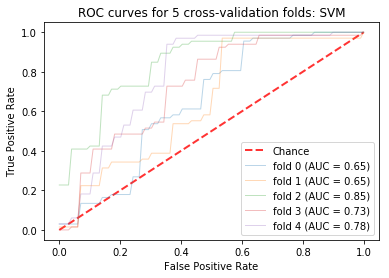

In [11]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

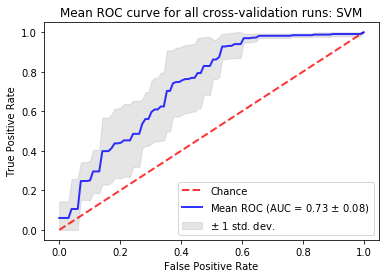

In [12]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [13]:
# Create a Naive Bayes classifier object with default parameters 
# (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, prec_NB, rec_NB = evaluate_classifier(folds=5, 
                                                                                     p=predictors, 
                                                                                     t=target, 
                                                                                     classifier=NB_classifier, 
                                                                                     mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

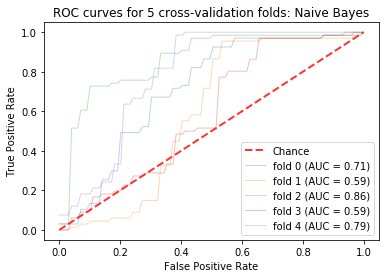

In [14]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

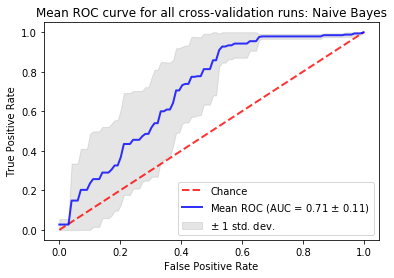

In [15]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Selected 3rd Classifier: Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
LR_classifier = LogisticRegression(solver='lbfgs')

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_LR, f1_scores_LR, tprs_LR, aucs_LR, prec_LR, rec_LR = evaluate_classifier(folds=5, 
                                                                                     p=predictors, 
                                                                                     t=target, 
                                                                                     classifier=LR_classifier, 
                                                                                     mean_fpr=mean_fpr)

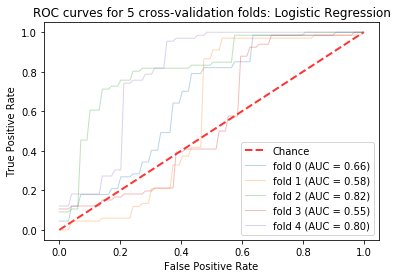

In [17]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

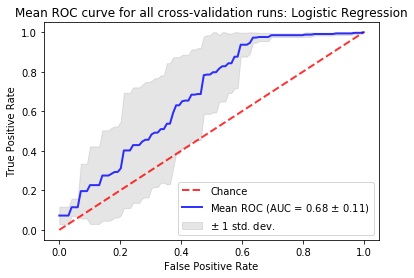

In [18]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

### Compare All Trained Classifiers

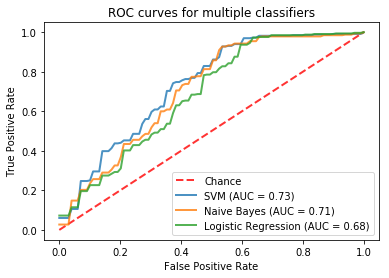

In [19]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_LR, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_LR)]), 
                              np.array(['SVM', 'Naive Bayes', 'Logistic Regression']))

In [20]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 
                                   'Naive Bayes' : accuracies_NB, 
                                   'Logistic Regression' : accuracies_LR})

In [21]:
accuracies_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.808403
std,0.029567,0.053465,0.029567
min,0.778947,0.715789,0.778947
25%,0.783505,0.762887,0.783505
50%,0.812500,0.804124,0.812500
75%,0.814433,0.822917,0.814433
max,0.852632,0.852632,0.852632


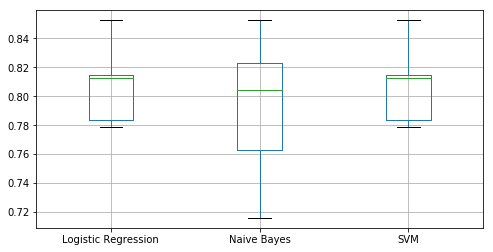

In [22]:
accuracies_df.boxplot(figsize=(8,4))

In [23]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 
                                  'Naive Bayes' : f1_scores_NB, 
                                  'Logistic Regression' : f1_scores_LR})

In [24]:
f1_scores_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.876278
std,0.017193,0.036598,0.017193
min,0.860927,0.808511,0.860927
25%,0.860927,0.839161,0.860927
50%,0.878378,0.872483,0.878378
75%,0.878378,0.882759,0.878378
max,0.902778,0.900000,0.902778


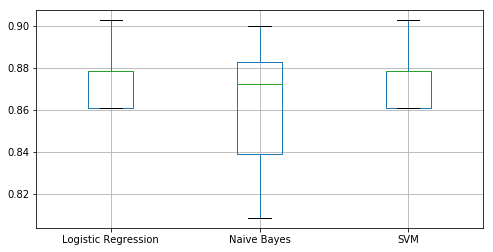

In [25]:
f1_scores_df.boxplot(figsize=(8,4))

### Comparision of SVM / Naive Bayes with Logistic Regression

In general the observation is that the logistic regression and SVM has a very similar performance in terms of accuracy and f1 score. 

Both the Logistic regression and SVM classfier have the same mean accuracy approximately 80% with similar variance as seen in the box plot. The Naive Bayes classifier also has a bit low but comparable accuracy of 79% however the variance is accuracy is on higher side.

Like the accuracy results the mean f1 score of logistic regression an SVM is also similar both being 87.6% with similar variance. The Naive Bayes, like before, is lagging behind a bit with an f1 score of 86% with a high variance.

However, SVM has a higher mean AUC of 73% as compared to logistic regression and Naive Bayes which are 71% and 68% respectively.

Conclusion so far: 
Both the SVM and Logistic regression have high mean accuracy and high f1 score with similar variance. AUC is higher for SVM as compared to Logistic regressiona and Naive Bayes. Based on this SVM seems to be a better choise.

## Task 2 (CS5062)
*Modify the code in both Lab 4 - Comparison of Classifiers.ipynb and Lab4_Functions.ipynb to boxplot precision and recall for the classifiers trained with loans_et4.csv. Update your conclusions from Task 1 after evaluating precision and recall.*

#### Boxplot precision and recall for the classifiers

In [26]:
# Compare the statistics of the Precision across all cross-validation folds (TODO: Fix plots)
precision_df = pd.DataFrame(data={'SVM' : prec_SVM,
                                  'Naive Bayes' : prec_NB,
                                  'Logistic Regression' : prec_LR
                                 })

In [27]:
precision_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.793400,0.800727,0.793400
std,0.026854,0.033546,0.026854
min,0.764706,0.760000,0.764706
25%,0.773810,0.789474,0.773810
50%,0.792683,0.792683,0.792683
75%,0.802469,0.810127,0.802469
max,0.833333,0.851351,0.833333


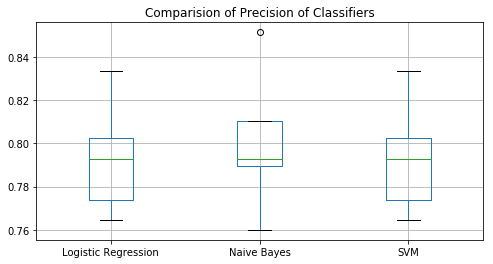

In [28]:
precision_df.boxplot(figsize=(8,4))
plt.title('Comparision of Precision of Classifiers')
plt.show()

In [29]:
# Compare the statistics of the recalls across all cross-validation folds
recalls_df = pd.DataFrame(data={'SVM' : rec_SVM, 
                                'Naive Bayes' : rec_NB,
                                'Logistic Regression' : rec_LR
                               })

In [30]:
recalls_df.describe()

,Logistic Regression,Naive Bayes,SVM
count,5.000000,5.000000,5.000000
mean,0.978969,0.930710,0.978969
std,0.008051,0.048427,0.008051
min,0.970149,0.863636,0.970149
25%,0.970149,0.895522,0.970149
50%,0.984848,0.954545,0.984848
75%,0.984848,0.969697,0.984848
max,0.984848,0.970149,0.984848


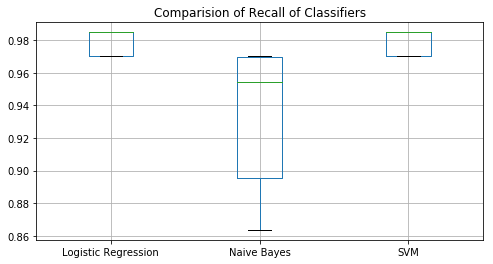

In [31]:
recalls_df.boxplot(figsize=(8,4))
plt.title('Comparision of Recall of Classifiers')
plt.show()

### Conclusion about the comparison of the classifiers reflects the observations about precision and recall

Precision and Recall can provide better information than the ROC curves for picking the best model when the two classes are not well balanced as in this case where 1/3 of the examples are in class 1.

- The Precision score for SVM and Logistic Regression is exactly the same 79.3% and Gaussian Naive Bias classifier have marginally better precision with 80%. 
- The box plot of precision score shows that the Naive Bias has comparatively low variance in precision score as compared to the other 2 classifiers.


- The Recall score for SVM and Logistic Regression classifier is exactly the same and both showing a very high average recall score of approximately 98%. 
- The Naive bias has a low recall score of 93% and also shows a very high variance which highlights that its not able to detect the False negatives properly.

We can safely say at this point that SVM can be potentially the best classifier for this binary classification task.

## Task 3 (CS5062)
- Pick a winner among the classifiers you have trained with loans_et4.csv. 
- Assume that it is important to minimise the false positives (i.e., Loan_Status predicted to be 1 wrongly). 
- Look up the training parameters for this classifier on the scikit-learn website. 
    - For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 
    - Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.
    - You do not have to build a better model but to show that you have explored some of its training parameters. 
- Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

### Grid Search to find the best parameters

Goal is to minimise the false positives.

#### Approach used:
1. **Optmize model for a better AUC**. AUC from the ROC plot can be used for this purpose as its an indication of TPR and FPR. We need to optimize for AUC score in grid search for the SVM classifier. The false positive rate measures the ratio of false positives within the negative samples. Ideally we want to see low FPR in this case. 

2. **Optimize the SVM for Precision score** using Grid search cross validation. Precision value is high if we have low False positives, Thus, improving SVM model parameters for better precision can help in getting less false positives.

References:
1. https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
2. https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [33]:
def model_optimization(score=''):
    # Important parameters in SVC are: "C", "gamma" and the "kernel"
    hyper_parameters = {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100],
                        'gamma':  [0.0001, 0.001, 0.01, 0.1, 1, 2, 5],
                        'kernel': ['linear', 'poly', 'rbf'],
                        'degree': [1, 2, 3, 4, 5],
                        'class_weight': [None, {0: 1 , 1: 3}, {0: 1 , 1: 2}], # more weight on 1 than 0 (Thanks Michel for the idea)
                        'probability' : [True]
                       }

    # Using a SVM classifier
    # The probabilty values need to be set as True to get the ROC curve
    SVM_clf = svm.SVC()

    # Using 5 fold cross-validation in grid search
    grid_search = GridSearchCV(SVM_clf, hyper_parameters, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(predictors, target)
    
    final_svm = grid_search.best_estimator_
    final_svm_params = grid_search.best_params_
    final_svm_score  = grid_search.best_score_

    return final_svm, final_svm_params, final_svm_score
    

### Optmize model for a better ROC AUC Score

In [34]:
%%time

# find the best parameters for the optimized model
best_svm_model, best_svm_params, best_svm_score = model_optimization(score='roc_auc')

print('This takes 3-5 minutes to run...')

This takes 5-7 minutes to run...
CPU times: user 12.9 s, sys: 1.3 s, total: 14.2 s
Wall time: 3min 30s


In [47]:
print("Best SVM classifier parameters set found by cross validation:\n", best_svm_params)
print()
print("Best score :", best_svm_score)

Best SVM classifier parameters set found by cross validation:
 {'class_weight': {0: 1, 1: 3}, 'C': 100, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True, 'degree': 1}

Best score : 0.7852426250409397


In [36]:
%%time
# Train and evaluate the classifier by applying 5-fold cross validation.
accuracies_opt, f1_scores_opt, tprs_opt, aucs_opt, prec_opt, rec_opt = evaluate_classifier(folds=5, 
                                                                                           p=predictors, 
                                                                                           t=target, 
                                                                                           classifier=best_svm_model, 
                                                                                           mean_fpr=mean_fpr)

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 295 ms


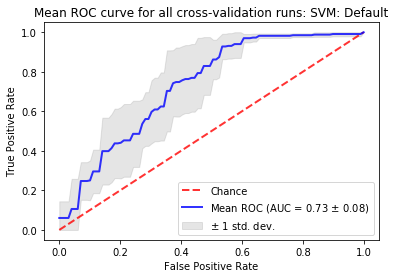

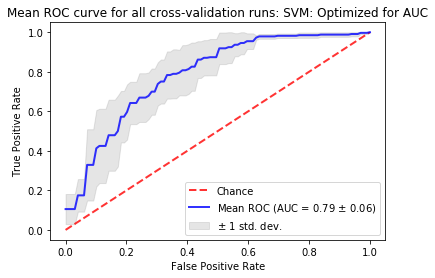

In [37]:
# Un-optimized SVM: Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM: Default')

# Optmized SVM: Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_opt, aucs_opt, 'SVM: Optimized for AUC')

### Observation:
The ROC curve shows that the AUC has improved form 73% to 79%. Also we can see that the FPR is lower in the optmized SVM classifier as comapred to the unoptimized classifier.

## Lets see the effect of Precision score in SVM in gridsearch
Optimize the SVM for Precision score

In [38]:
%%time

# find the best parameters for the optimized model
best_svm_model2, best_svm_params2, best_svm_score2 = model_optimization(score='precision')

print('This takes almost 5 minutes to run...')

This takes almost 5 minutes to run...
CPU times: user 10.2 s, sys: 1.76 s, total: 12 s
Wall time: 5min 49s


In [39]:
print("Best SVM classifier parameters for Precision Score:\n", best_svm_params2)
print()
print("Best score :", best_svm_score2)

Best SVM classifier parameters for Precision Score:
 {'class_weight': {0: 1, 1: 2}, 'C': 0.001, 'gamma': 2, 'kernel': 'poly', 'probability': True, 'degree': 4}

Best score : 0.7954967812006408


In [40]:
%%time
# Train and evaluate the classifier by applying 5-fold cross validation.
accuracies_opt2, f1_scores_opt2, tprs_opt2, aucs_opt2, prec_opt2, rec_opt2 = evaluate_classifier(folds=5, 
                                                                                           p=predictors, 
                                                                                           t=target, 
                                                                                           classifier=best_svm_model2, 
                                                                                           mean_fpr=mean_fpr)

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 183 ms


In [41]:
# Compare the statistics of the Precision across all cross-validation folds (TODO: Fix plots)
precision_svm_df = pd.DataFrame(data={'SVM: Deafult' : prec_SVM,
                                      'SVM: Best AUC' : prec_opt,
                                      'SVM: Precision' : prec_opt2,
                                 })

In [42]:
precision_svm_df.describe()

,SVM: Best AUC,SVM: Deafult,SVM: Precision
count,5.000000,5.000000,5.000000
mean,0.793400,0.793400,0.795565
std,0.026854,0.026854,0.030994
min,0.764706,0.764706,0.764706
25%,0.773810,0.773810,0.773810
50%,0.792683,0.792683,0.792683
75%,0.802469,0.802469,0.802469
max,0.833333,0.833333,0.844156


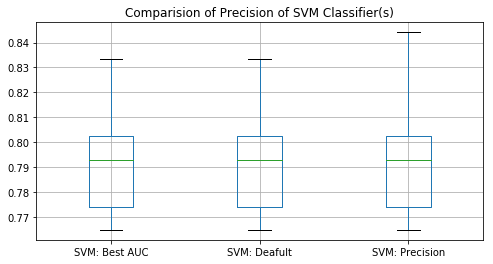

In [43]:
precision_svm_df.boxplot(figsize=(8,4))
plt.title('Comparision of Precision of SVM Classifier(s)')
plt.show()

### Observation on Precision plots
There is no minor improvement in the precision value after tuning the SVM classifier hyper-parameters for rpecision score. The mean precision value after tuning is 79.5% from 79.3%. The variance of the Precision value if lower when we use "SVM:Precision" which is a good sign, but its vry minor.

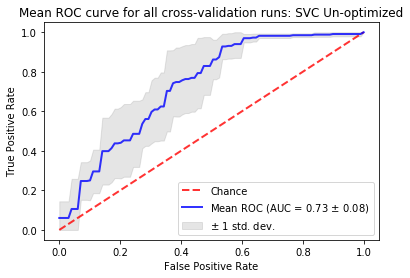

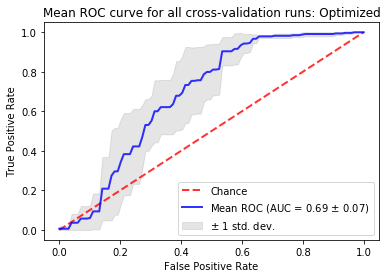

In [44]:
# Un-optimized SVM: Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVC Un-optimized')

# Optmized SVM: Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_opt2, aucs_opt2, 'Optimized')

#### Observation on ROC plots
The ROC has reduced when we use SVM for precision optimization

### Parameter comparision for the SVM optimized classifiers

In [45]:
# Comparision of the Deafult SVM vs Best SVM(with tuned hyperparameters) classifier for better AUC
SVM_classifier2_df = pd.DataFrame(data={'SVM: Deafult'   : SVM_classifier.get_params(),
                                        'SVM: Best AUC' : best_svm_model.get_params(),
                                        'SVM: Precision' : best_svm_model2.get_params()
                                      })

SVM_classifier2_df

,SVM: Best AUC,SVM: Deafult,SVM: Precision
C,100,1,0.001
cache_size,200,200,200
class_weight,"{0: 1, 1: 3}",None,"{0: 1, 1: 2}"
coef0,0,0,0
decision_function_shape,ovr,ovr,ovr
degree,1,3,4
gamma,0.001,auto,2
kernel,rbf,rbf,poly
max_iter,-1,-1,-1
probability,True,True,True
